In [30]:
import torch  
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam, SGD
from PIL import Image
from torchvision import transforms
from typing import Any, Callable, Type

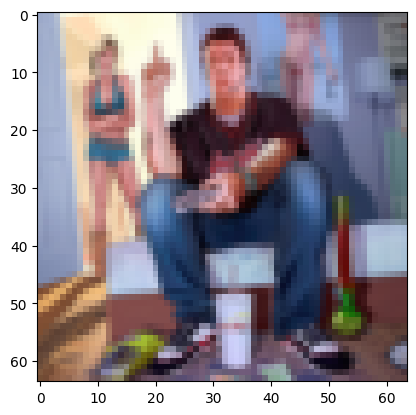

In [31]:
in_img = Image.open('data/sample-img.png')
# scale down and convert to tensor
in_img = transforms.Compose([transforms.Resize((64, 64)),transforms.ToTensor()])(in_img)
# change order of dimensions 
in_img = in_img.permute(1, 2, 0)
# remove alpha
in_img = in_img[:, :, :3]
plt.imshow(in_img)

In [32]:
class NerfNetwork(nn.Module):
    # this is a cppn network, that maps from (x,y) to (r,g,b)
    def __init__(self):
        super(NerfNetwork, self).__init__()
        self.fc1 = nn.Linear(2, 128,   dtype=torch.float32)
        self.fc2 = nn.Linear(128, 128, dtype=torch.float32)
        self.fc3 = nn.Linear(128, 128, dtype=torch.float32)
        self.fc4 = nn.Linear(128, 3,   dtype=torch.float32)
        self.R = nn.ReLU()

    def forward(self, x):
        x = self.R(self.fc1(x))
        x = self.R(self.fc2(x))
        x = self.R(self.fc3(x))
        x = torch.sigmoid(self.fc4(x))
        return x

In [33]:
def train(
    net: Type[nn.Module],
    img: torch.tensor,
    loss_fn: Callable[[Any, Any], torch.float],
    num_epochs: int,
    lr: float = 0.001,
    use_adam: bool = False,
) -> tuple[Type[nn.Module], list[float]]:
    f = net()
    opt = Adam(f.parameters(), lr=lr) if use_adam else SGD(f.parameters(), lr=lr)
    losses = []
    
    coords = torch.stack([torch.tensor([i / img.shape[0], j / img.shape[1]], dtype=torch.float32) for i, j in np.ndindex(img.shape[:2])]) # R^{x * y, 2}
    target = img.reshape(-1, 3) # R^{x * y, 3}

    for ep in range(num_epochs):
        opt.zero_grad()
        y_hat = f(coords)  # Forward pass through the network for all coordinates at once
        loss = loss_fn(y_hat, target)
        loss.backward()
        opt.step()
        if ep % 100 == 0:
            print(f"Epoch {ep+1}/{num_epochs}, Loss: {loss.item()}")
        losses.append(loss.item())

    return f, losses

In [34]:
L = nn.MSELoss()
epochs = 500
f, losses = train(NerfNetwork, in_img, L, epochs, lr=0.001, use_adam=True)

Epoch 1/500, Loss: 0.060387324541807175
Epoch 101/500, Loss: 0.03444242104887962
Epoch 201/500, Loss: 0.029024044051766396
Epoch 301/500, Loss: 0.024708375334739685
Epoch 401/500, Loss: 0.022121168673038483


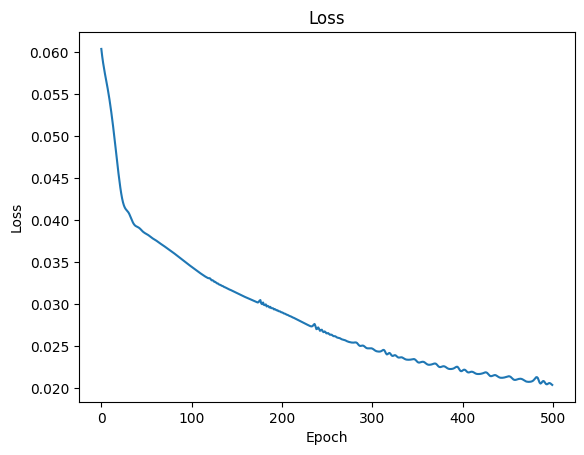

In [35]:
losses = torch.Tensor(losses)
losses = losses.reshape(epochs,-1) # losses per epoch
losses = losses.mean(axis=1)

plt.plot(losses)
plt.title("Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

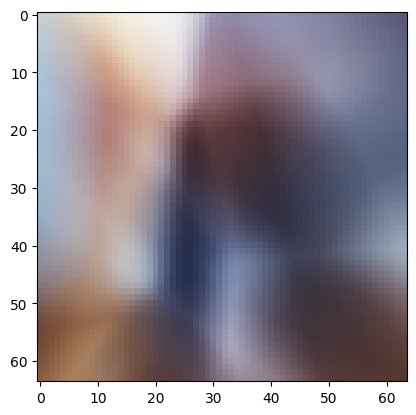

In [36]:
out_img = np.zeros((in_img.shape[0], in_img.shape[1], 3))
for i in range(out_img.shape[0]):
    for j in range(out_img.shape[1]):
        x = torch.tensor([i / out_img.shape[0], j / out_img.shape[1]], dtype=torch.float32)
        out_img[i, j] = f(x).detach().numpy()
plt.imshow(out_img)

## Now use a positional encoding 
$$
\begin{align}
\gamma(x,y) =&[\sin(\pi x), \cos(\pi x),\sin(\pi y), \cos(\pi y), \\
&\sin(2 \pi x), \cos(2 \pi x),\sin(2 \pi y), \cos(2 \pi y), \\
&\ldots\\
&\sin(2^{L-1}\pi x), \cos(2^{L-1}\pi x),\sin(2^{L-1}\pi y), \cos(2^{L-1}\pi y)] \in \mathbb{R}^{4*L}
\end{align}
$$

Not sure about the $\in \mathbb{R}^{4*L}$ part

In [37]:
def positional_encoding(xys: torch.Tensor, l_max=10) -> torch.Tensor:
    xys = xys.float()  # Ensure the inputs are floats for trigonometric operations
    pi = torch.pi
    frequencies = 2**torch.arange(l_max) * pi  # Calculate frequency levels

    # Preallocate the result tensor
    results = torch.zeros(xys.size(0), 4 * l_max)

    # Calculate sine and cosine for each frequency and stack them
    for i, freq in enumerate(frequencies):
        results[:, 4 * i + 0] = torch.sin(xys[:, 0] * freq)
        results[:, 4 * i + 1] = torch.cos(xys[:, 0] * freq)
        results[:, 4 * i + 2] = torch.sin(xys[:, 1] * freq)
        results[:, 4 * i + 3] = torch.cos(xys[:, 1] * freq)

    return results

xy = torch.tensor([[0.5, 0.5]], dtype=torch.float32)
positional_encoding(xy)

tensor([[ 1.0000e+00, -4.3711e-08,  1.0000e+00, -4.3711e-08, -8.7423e-08,
         -1.0000e+00, -8.7423e-08, -1.0000e+00,  1.7485e-07,  1.0000e+00,
          1.7485e-07,  1.0000e+00,  3.4969e-07,  1.0000e+00,  3.4969e-07,
          1.0000e+00,  6.9938e-07,  1.0000e+00,  6.9938e-07,  1.0000e+00,
          1.3988e-06,  1.0000e+00,  1.3988e-06,  1.0000e+00,  2.7975e-06,
          1.0000e+00,  2.7975e-06,  1.0000e+00,  5.5951e-06,  1.0000e+00,
          5.5951e-06,  1.0000e+00,  1.1190e-05,  1.0000e+00,  1.1190e-05,
          1.0000e+00,  2.2380e-05,  1.0000e+00,  2.2380e-05,  1.0000e+00]])

In [38]:
class NerfNetworkEncoded(nn.Module):
    def __init__(self):
        super(NerfNetworkEncoded, self).__init__()
        self.num_frequencies = 10
        self.fc1 = nn.Linear(40, 256,   dtype=torch.float32)
        self.fc2 = nn.Linear(256, 256, dtype=torch.float32)
        self.fc3 = nn.Linear(256, 256, dtype=torch.float32)
        self.fc4 = nn.Linear(256, 256, dtype=torch.float32)
        self.fc5 = nn.Linear(256, 3,   dtype=torch.float32)
        self.R = nn.ReLU()

    def forward(self, x):
        x = positional_encoding(x, self.num_frequencies)
        x = self.R(self.fc1(x))
        x = self.R(self.fc2(x))
        x = self.R(self.fc3(x))
        x = self.R(self.fc4(x))
        x = torch.sigmoid(self.fc5(x))
        return x

In [39]:
L = nn.MSELoss()
epochs = 500
f, losses = train(NerfNetworkEncoded, in_img, L, epochs, lr=0.001, use_adam=True)

losses = torch.Tensor(losses)
losses = losses.reshape(epochs,-1) # losses per epoch
losses = losses.mean(axis=1)

Epoch 1/500, Loss: 0.05985302850604057
Epoch 101/500, Loss: 0.006152719724923372
Epoch 201/500, Loss: 0.001949329860508442
Epoch 301/500, Loss: 0.0011194887338206172
Epoch 401/500, Loss: 0.000617829617112875


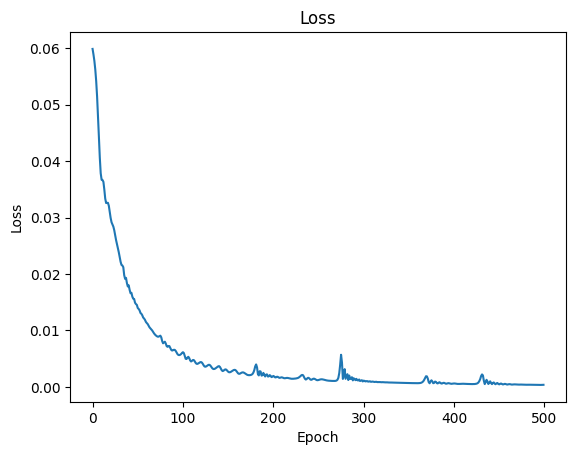

In [40]:
plt.plot(losses)
plt.title("Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

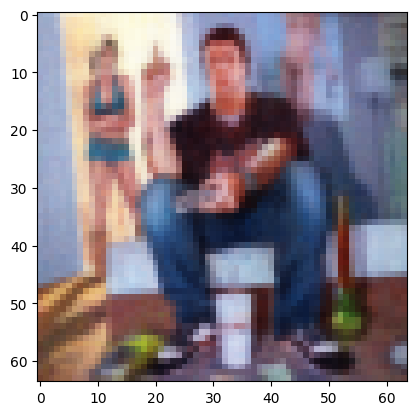

In [41]:
coords = torch.stack(
    [torch.tensor([i / out_img.shape[0], j / out_img.shape[1]], dtype=torch.float32) for i, j in np.ndindex(out_img.shape[:2])]
) # R^{x * y, 2}
y_hat = f(coords).detach().numpy().reshape(out_img.shape)
plt.imshow(y_hat)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.57822216..0.7306595].


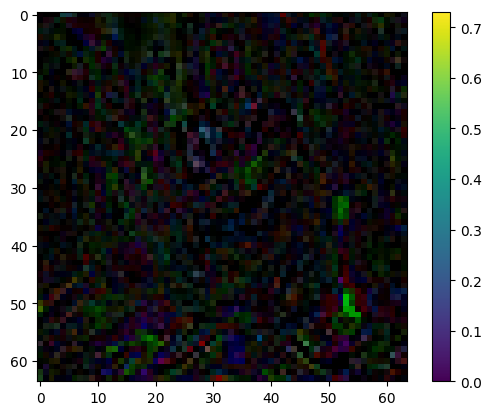

In [42]:
# show difference 
plt.imshow((in_img - y_hat)*5)
plt.colorbar()
plt.show()